# Project - Crop disease Identification DL model


## Import Libraries

In [4]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import models, layers
import warnings
warnings.filterwarnings('ignore')

## Import Data

In [84]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r'C:\Users\Hp\Downloads\Practice Data frames\Database\Deep Learning Project Crop disease\PlantVillage\Capstone',
    shuffle = True,
    image_size=(256,256)
)

Found 2153 files belonging to 4 classes.


In [63]:
for i, j in dataset.take(5):
    print(i.numpy().shape)
    print(j.numpy())

(32, 256, 256, 3)
[1 1 0 2 0 2 0 0 1 1 0 0 1 1 0 1 1 1 0 1 0 1 1 0 0 1 2 1 1 2 0 1]
(32, 256, 256, 3)
[0 1 0 1 0 0 0 1 0 0 1 0 2 1 1 1 1 1 1 2 1 0 0 1 1 1 0 0 1 0 1 2]
(32, 256, 256, 3)
[1 1 0 1 0 2 1 0 0 2 0 0 1 1 1 0 0 1 1 0 1 0 0 0 0 0 1 0 0 1 1 0]
(32, 256, 256, 3)
[1 0 0 1 1 1 0 1 1 2 1 1 0 0 0 0 1 2 0 0 0 1 1 1 0 1 2 0 1 0 1 1]
(32, 256, 256, 3)
[0 0 1 0 0 0 1 0 1 0 1 0 0 2 0 0 0 1 2 2 1 0 0 0 0 1 1 1 0 1 2 1]


In [9]:
len(dataset)

68


- Total 68 batch each batch containing 32 images of size 256x256 with 3 layers of RGB


## Visualizing Data

In [10]:
import matplotlib.pyplot as plt

In [11]:
classes = dataset.class_names
classes

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

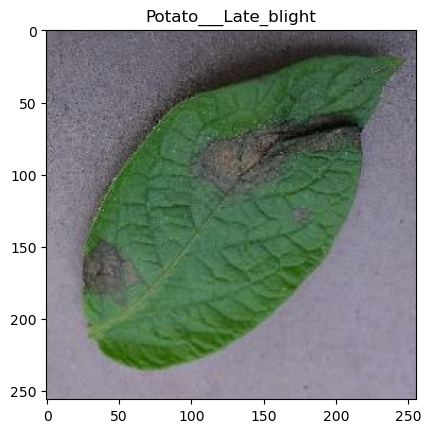

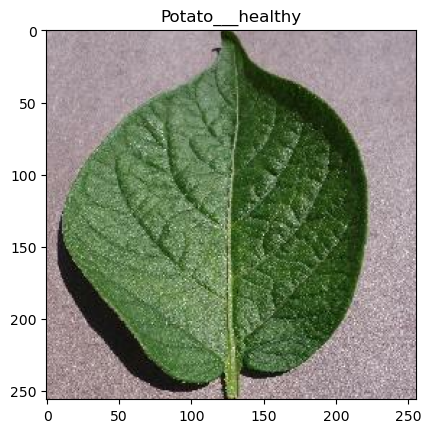

In [178]:
for i,j in dataset.take(2):
    plt.imshow(i.numpy()[0].astype("uint8")) #uint8 to convert float to integer
    plt.title(classes[j[0].numpy()])
    plt.show()

## Splitting data in 3 part - Training, Validation and testing

In [12]:
train = dataset.take(int(len(dataset)*0.8))
len(train)

54

In [13]:
temp = dataset.skip(int(len(dataset)*0.8))
len(temp)

14

In [15]:
val = temp.take(int(len(temp)*0.5))
len(val)

7

In [16]:
test = temp.skip(int(len(temp)*0.5))
len(test)

7

In [48]:
# Creating a Def function to split data

def split_data(ds, train_split = 0.8, test_split = 0.2, shuffle = True, shuffle_size = 1000):
    if shuffle:
        ds = ds.shuffle(shuffle_size)
    train_set = ds.take(int(len(ds)*train_split))
    temp = ds.skip(int(len(ds)*train_split))
    val_set = temp.take(int(len(temp)*0.5))
    test_set = temp.skip(int(len(temp)*0.5))
    
    return train_set, val_set, test_set

In [49]:
train, val, test = split_data(dataset)

In [50]:
print(f'''

Length of original dataset = {len(dataset)}
Length of train dataset = {len(train)}
Length of validation dataset = {len(val)}
Length of test dataset = {len(test)}

'''
)



Length of original dataset = 68
Length of train dataset = 54
Length of validation dataset = 7
Length of test dataset = 7




- Taking 80 percent of data set for training. 
- 50 percent of remaining test dataset will be used for validating epochs.
- Other 50 percent of test data will be used for calculating the performance of model

## Model optimization

In [52]:
train = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 
val = val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

- Cache memorizes and eliminates the preprocessing after 1st epoch thus increasing effeciency and reducing training time.
- Prefetch loads or keeps the next batch ready while training is previous batch.

### Scaling

In [53]:
scale_resize = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

### Data Augmentation

In [54]:
data_aug = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

## Model Building and training

In [55]:
# Builing model and its layers 

model = models.Sequential([
    scale_resize,
    data_aug,
    layers.Conv2D(32, kernel_size = (3, 3), activation = 'relu', input_shape = (32, 256, 256, 3)),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation = 'relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation = 'relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPool2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPool2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(3, activation = 'softmax')
])

model.build(input_shape=(32, 256, 256, 3))

In [128]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 sequential_4 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 127, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                 

In [57]:
# Compiling

model.compile(
    optimizer ='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy']
)

In [58]:
# Training Model on the train dataset

record = model.fit(
    train, 
    epochs=50,
    verbose=1,
    batch_size = 32,
    validation_data=val
)

Epoch 1/50
54/54 [==============================] - 39s 655ms/step - loss: 0.8681 - accuracy: 0.5145 - val_loss: 0.7381 - val_accuracy: 0.6920
Epoch 2/50
54/54 [==============================] - 35s 643ms/step - loss: 0.5871 - accuracy: 0.7610 - val_loss: 0.4915 - val_accuracy: 0.8348
Epoch 3/50
54/54 [==============================] - 35s 644ms/step - loss: 0.3995 - accuracy: 0.8432 - val_loss: 0.3500 - val_accuracy: 0.8393
Epoch 4/50
54/54 [==============================] - 35s 642ms/step - loss: 0.2911 - accuracy: 0.8825 - val_loss: 0.2729 - val_accuracy: 0.9062
Epoch 5/50
54/54 [==============================] - 35s 641ms/step - loss: 0.2522 - accuracy: 0.9028 - val_loss: 0.2514 - val_accuracy: 0.8973
Epoch 6/50
54/54 [==============================] - 35s 643ms/step - loss: 0.2030 - accuracy: 0.9201 - val_loss: 0.1383 - val_accuracy: 0.9554
Epoch 7/50
54/54 [==============================] - 35s 647ms/step - loss: 0.1671 - accuracy: 0.9352 - val_loss: 0.1530 - val_accuracy: 0.9598

In [59]:
# Test (unseen data) accuracy

test_accuracy = model.evaluate(test)

7/7 [==============================] - 2s 146ms/step - loss: 0.0905 - accuracy: 0.9688


In [60]:
# Performace Evaluation

import pandas as pd
import seaborn as sns

record_df = pd.DataFrame(record.history)
record_df

,loss,accuracy,val_loss,val_accuracy
0,0.868145,0.514468,0.738125,0.691964
1,0.587053,0.760995,0.491453,0.834821
2,0.399531,0.843171,0.349964,0.839286
3,0.291054,0.882523,0.272935,0.906250
4,0.252212,0.902778,0.251440,0.897321
5,0.203031,0.920139,0.138302,0.955357
6,0.167132,0.935185,0.152960,0.959821
7,0.157141,0.939236,0.165666,0.933036
8,0.193224,0.921875,0.187340,0.928571
9,0.161119,0.940972,0.325573,0.892857


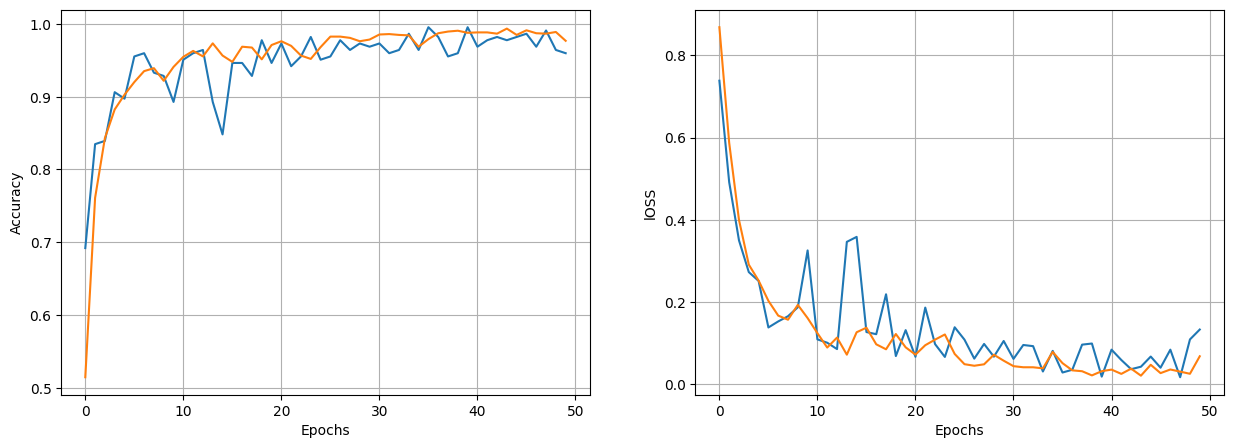

In [61]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.lineplot(x = record_df.index, y = record_df['val_accuracy'])
sns.lineplot(x = record_df.index, y = record_df['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.grid()

plt.subplot(1,2,2)
sns.lineplot(x = record_df.index, y = record_df['val_loss'])
sns.lineplot(x = record_df.index, y = record_df['loss'])
plt.ylabel('lOSS')
plt.xlabel('Epochs')
plt.grid()

plt.savefig("Performace.png")

plt.show()



1/1 [==============================] - 0s 364ms/step


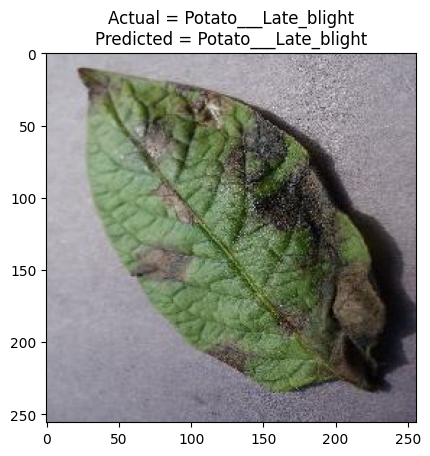

In [87]:
for i,j in dataset.take(1):
    plt.imshow(i.numpy()[0].astype('uint64'))
    predicted = model.predict(i)
    plt.title(f'Actual = {classes[j[0]]}\nPredicted = {classes[np.argmax(predicted[0])]}')
    

## Saving Model 

In [33]:
model.save(r'C:\Users\Hp\Downloads\Practice Data frames\Capstone\CNN\{1}')

INFO:tensorflow:Assets written to: C:\Users\Hp\Downloads\Practice Data frames\Capstone\CNN\{1}\assets


INFO:tensorflow:Assets written to: C:\Users\Hp\Downloads\Practice Data frames\Capstone\CNN\{1}\assets
